# 4. Adjoint optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Dr.Jit library. Those are explained in the [Dr.Jit documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Dr.Jit records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')

In [2]:
from matplotlib import pyplot as plt

import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
def show_image(img, title):
    plt.imshow(mi.util.convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

scene = mi.load_file('../scenes/cbox.xml', res=128, spp=16, max_depth=3, integrator='prb')

2022-02-14 16:39:59 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "llvm_ad_rgb"..

2022-02-14 16:39:59 INFO main [Scene] Embree ready. (took 23ms)

2022-02-14 16:39:59 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 40ms).

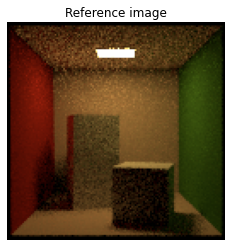

In [4]:
# dr.set_log_level(3)
integrator = scene.integrator()
image_ref = integrator.render(scene, seed=0)
show_image(image_ref, 'Reference image')

In [5]:
image_ref = integrator.render(scene, seed=0)
dr.eval(image_ref)

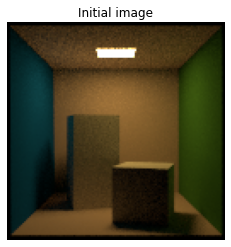

In [7]:
# Update scene parameter
params = mi.traverse(scene)
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = mi.Color3f(params[key])
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
image_init = integrator.render(scene, seed=0, spp=128)
show_image(image_init, 'Initial image')

In [8]:
opt = mi.ad.Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [9]:
def compute_image_loss(img, obj_func):
    dr.enable_grad(img)
    ob_val = obj_func(img)
    dr.backward(ob_val)
    image_loss = dr.grad(img)
    dr.set_grad(img, 0.0)
    return image_loss

def MSE(img):
    return dr.hsum_async(dr.sqr(img - image_ref)) / len(img)

mi.set_log_level(mi.LogLevel.Error)

errors = []
for it in range(50):
#     img = mitsuba.python.ad.render(scene)
#     loss = ...
#     dr.backward(loss)

    # Perform a differentiable rendering of the scene
    with dr.suspend_grad():
        image = integrator.render(scene, seed=0, spp=16)
    image_adj = compute_image_loss(image, MSE)
    integrator.render_backward(scene, opt, image_adj, seed=0, spp=16)

    # Optimizer: take a gradient step
    opt.step()

    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Optimizer: Update the scene parameters
    opt.update()

    err_ref = dr.hsum(dr.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

Iteration 000: error=0.920982
Iteration 001: error=0.786878
Iteration 002: error=0.667972
Iteration 003: error=0.563303
Iteration 004: error=0.469854
Iteration 005: error=0.38568
Iteration 006: error=0.311803
Iteration 007: error=0.247949
Iteration 008: error=0.193722
Iteration 009: error=0.148473
Iteration 010: error=0.111359
Iteration 011: error=0.0818369
Iteration 012: error=0.0592622
Iteration 013: error=0.0428433
Iteration 014: error=0.0316426
Iteration 015: error=0.0246277
Iteration 016: error=0.0207591
Iteration 017: error=0.019089
Iteration 018: error=0.0188365
Iteration 019: error=0.0194167
Iteration 020: error=0.0204243
Iteration 021: error=0.0213565
Iteration 022: error=0.0201898
Iteration 023: error=0.0184917
Iteration 024: error=0.0164234
Iteration 025: error=0.0141244
Iteration 026: error=0.0117252
Iteration 027: error=0.00935949
Iteration 028: error=0.00716631
Iteration 029: error=0.00527703
Iteration 030: error=0.00379401
Iteration 031: error=0.00277039
Iteration 032: e

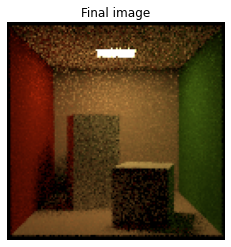

In [10]:
with dr.suspend_grad():
    image_final = integrator.render(scene, seed=0, spp=8)
    show_image(image_final, 'Final image')

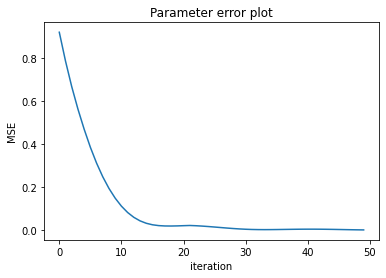

In [11]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Parameter error plot');

### *Reference API*

- [<code>mitsuba.core.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)